In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd

In [2]:
def build_normal(loc=0, scale=1.0, size=10, min_=-10.0, max_=10.0, seed=None):
    if seed is not None:
        np.random.seed(seed)
    r = np.random.normal(loc=loc, scale=scale, size=size)
    r = np.minimum(np.maximum(min_, r), max_)
    return r

def ret_from_track(df, li_undl):
    return  df[li_undl].pct_change().dropna().values

def get_vol(ret, dt):
    ylds = 1.0+ret
    return np.sqrt(np.mean(np.log(ylds)**2))*np.sqrt(1/dt)
    
def get_basket_vol(df, li_undl, dt, weight):
    ret = ret_from_track(df, li_undl)
    wret = weight*ret
    wret = wret.sum(axis=1)
    return get_vol(wret, dt)

def get_corr(df):
    li_arr = [df[u].values for u in df.columns]
    return np.corrcoef(li_arr)


## Constant vol tracks

In [4]:
np.random.seed(4321)

n_path = 5     # nb of monte carlo paths
rate = 0.02     # rate 0.01=1%
vol = 0.25      # vol 0.25
n_bd = 252*3     # nb of bdays for a path
dt = 1.0/260    # bday duration in year
today = pd.Timestamp.today().date()


ret = (rate-vol**2/2)*dt+vol*np.sqrt(dt)*build_normal(size=(n_bd, n_path))
# vols = np.array([build_normal(loc=0.25, scale=0.0000000001, size=n_bd, min_=0.01, max_=0.60)]*5)
# ret = np.array([[(rate-v**2/2)*dt+v*np.sqrt(dt)*r for v, r in zip(vol, build_normal(size=n_bd))] for vol in vols]).T
ret[0, :] = 0
ylds = (1.0+ret)
tracks = ylds.cumprod(axis=0)

dates = pd.date_range(start=today, periods=n_bd, freq='B')
dfi = pd.DataFrame(data=tracks, index=dates, columns=['track'+str(1+i) for i in range(n_path)])

dfi.info()
display(dfi.head(3))
display(dfi.tail(3))

print('\ncorrel matrix')
print(get_corr(dfi))

print('\nrealised vols')
for u in dfi.columns:
    print(u, get_basket_vol(dfi, [u], dt, [1]))
    

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 756 entries, 2018-11-05 to 2021-09-27
Freq: B
Data columns (total 5 columns):
track1    756 non-null float64
track2    756 non-null float64
track3    756 non-null float64
track4    756 non-null float64
track5    756 non-null float64
dtypes: float64(5)
memory usage: 35.4 KB


,track1,track2,track3,track4,track5
2018-11-05,1.000000,1.000000,1.000000,1.000000,1.00000
2018-11-06,0.991086,0.988311,1.034504,1.010148,0.98240
2018-11-07,0.996116,0.990276,1.047314,0.987196,0.96086


,track1,track2,track3,track4,track5
2021-09-23,1.125280,1.339740,1.429421,1.009030,1.255059
2021-09-24,1.150918,1.313934,1.440480,1.008181,1.267824
2021-09-27,1.195137,1.307515,1.412126,1.013949,1.264965



correl matrix
[[ 1.          0.59319118 -0.25440052 -0.55600336  0.50238713]
 [ 0.59319118  1.         -0.1138696  -0.51729025  0.61332553]
 [-0.25440052 -0.1138696   1.          0.35002566 -0.08647017]
 [-0.55600336 -0.51729025  0.35002566  1.         -0.29859757]
 [ 0.50238713  0.61332553 -0.08647017 -0.29859757  1.        ]]

realised vols
track1 0.254283604953
track2 0.245305244007
track3 0.247569146385
track4 0.253333644353
track5 0.247757044234


## Stochastic vol tracks

In [5]:
np.random.seed(4321)

n_path = 5     # nb of monte carlo paths
rate = 0.02     # rate 0.01=1%
n_bd = 252*3     # nb of bdays for a path
dt = 1.0/260    # bday duration in year
today = pd.Timestamp.today().date()

avg_vol = build_normal(loc=0.2, scale=0.1, size=n_path, min_=0.05, max_=0.50)
# avg_vol = [0.25 for i in range(len(avg_vol))]
vols = np.array([build_normal(loc=v, scale=0.05, size=n_bd, min_=0.01, max_=0.60) for v in avg_vol])
ret = np.array([[(rate-v**2/2)*dt+v*np.sqrt(dt)*r for v, r in zip(vol, build_normal(size=n_bd))] for vol in vols]).T
ret[0, :] = 0
ylds = (1.0+ret)
tracks = ylds.cumprod(axis=0)

dates = pd.date_range(start=today, periods=n_bd, freq='B')
df = pd.DataFrame(data=tracks, index=dates, columns=['track'+str(1+i) for i in range(n_path)])

df.info()
display(df.head(3))
display(df.tail(3))

print(vols)

print('\ncorrel matrix')
print(get_corr(df))

print('\navg_vol\n', avg_vol)
print('\nrealised vols')
for u in df.columns:
    print(u, get_basket_vol(df, [u], dt, [1]))
    

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 756 entries, 2018-11-05 to 2021-09-27
Freq: B
Data columns (total 5 columns):
track1    756 non-null float64
track2    756 non-null float64
track3    756 non-null float64
track4    756 non-null float64
track5    756 non-null float64
dtypes: float64(5)
memory usage: 35.4 KB


,track1,track2,track3,track4,track5
2018-11-05,1.000000,1.000000,1.000000,1.000000,1.000000
2018-11-06,0.994895,0.982716,1.038262,1.001071,0.997844
2018-11-07,1.001589,0.962658,1.017907,1.005483,0.984785


,track1,track2,track3,track4,track5
2021-09-23,0.692751,0.532171,1.280789,1.318817,1.433171
2021-09-24,0.688351,0.532604,1.301374,1.321368,1.431258
2021-09-27,0.688598,0.534984,1.306199,1.321698,1.440787


[[ 0.09473928  0.08579217  0.23475868 ...,  0.11586583  0.17016342
   0.1074878 ]
 [ 0.31599261  0.28656578  0.22750237 ...,  0.27177903  0.2552781
   0.28666242]
 [ 0.25316525  0.36206486  0.38000876 ...,  0.32254386  0.34794979
   0.33047979]
 [ 0.29123801  0.15587963  0.19354063 ...,  0.10409381  0.18374236
   0.10277824]
 [ 0.18907723  0.15430989  0.10807295 ...,  0.12540713  0.19071497
   0.07361941]]

correl matrix
[[ 1.          0.7680106  -0.74200364 -0.69140764 -0.77712518]
 [ 0.7680106   1.         -0.69725634 -0.83575028 -0.8351512 ]
 [-0.74200364 -0.69725634  1.          0.71224737  0.86697986]
 [-0.69140764 -0.83575028  0.71224737  1.          0.86059914]
 [-0.77712518 -0.8351512   0.86697986  0.86059914  1.        ]]

avg_vol
 [ 0.12334785  0.29611947  0.3456347   0.14702073  0.17352326]

realised vols
track1 0.136068698244
track2 0.30408633013
track3 0.347489188801
track4 0.157385572424
track5 0.179710282934


## Random Basket vol

In [13]:
def get_basket_vol_2(ret, weight, dt):
    wret = weight*ret
    wret = wret.sum(axis=1)
    vol = get_vol(wret, dt)
    return vol

def get_basket_vol_sliding_window(df, undls, dt, weight, period):
    arr = df[undls].values
    ret = arr[1:]/arr[:-1]-1.0
    for start_date in range(len(df)-period):
#         print(start_date, end=',')
        sub_ret = ret[start_date: start_date+period]
        vol = get_basket_vol_2(sub_ret, weight, dt)
        li_vol.append(vol)
    return li_vol


In [14]:
n_undl = 3
period = 252
start_date = 0
end_date = start_date+period
weight = np.ones(n_undl)*1.0/n_undl

print('\nweight', weight)

undls = np.random.choice(df.columns, size=n_undl, replace=False)
print('\nundls', undls)

dfs = df[undls].iloc[start_date:end_date]
display(dfs.tail(3))
dfs.info()

# def get_basket_vol_period(df, undls, start_date, end_date):
#     dfs = df.iloc[start_date:end_date]
#     return get_basket_vol(dfs, undls, dt, weight)

li_vol = []

vols = get_basket_vol_sliding_window(df, undls, dt, weight, period)



weight [ 0.33333333  0.33333333  0.33333333]

undls ['track3' 'track2' 'track1']


,track3,track2,track1
2019-10-18,0.991618,0.750484,0.938081
2019-10-21,1.001786,0.743490,0.932901
2019-10-22,1.006120,0.726089,0.935671


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2018-11-05 to 2019-10-22
Freq: B
Data columns (total 3 columns):
track3    252 non-null float64
track2    252 non-null float64
track1    252 non-null float64
dtypes: float64(3)
memory usage: 7.9 KB


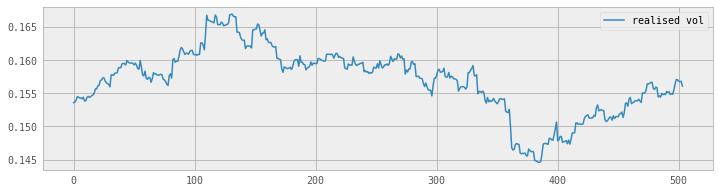

In [15]:
dfv = pd.DataFrame(vols, columns=['realised vol'])

dfv.plot(figsize=(12, 3))

In [ ]:
# np.random.seed(1234)
# avg_vol = build_normal(loc=0.2, scale=0.1, size=n_path, min_=0.05, max_=0.50)
# print('avg_vol\n', avg_vol, '\n')
# vols = np.array([build_normal(loc=v, scale=0.02, size=n_bd, min_=0.01, max_=0.60) for v in avg_vol])
# print('vol\n', vol, '\n')

# # returns = np.array([(rate-v**2/2)*dt+v*np.sqrt(dt)*build_normal(size=n_bd) for v in vol])

# print('v\n', v, '\n')

# # rnd_normal = build_normal(size=n_bd)
# ret = np.array([[(rate-v**2/2)*dt+v*np.sqrt(dt)*r for v, r in zip(vol, 
#                                                                   (size=n_bd))] for vol in vols])
# ret

In [ ]:
# a = dfi['track1']
# ret = a.pct_change().dropna().values
# yields = 1.0+ret
# lret = np.log(yields)
# lret_sq = np.log(yields)**2
# np.sqrt(np.mean(lret_sq))*np.sqrt(1/dt)